# DenoiseNet

DenoiseNet is a neural network that takes in a raw, uncleaned pointcloud, and outputs a clean pointcloud with a lot less noisy points

In [1]:
import os
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Dataset

A synthetic dataset will be created from the ModelNet10 dataset. ModelNet10 is a dataset made up of mesh files of 10 different types of objects. Using these mesh files, it is possible to sample points to turn the dataset into a collection of point cloud files. Our ground truth samples will be a result of these sampled point clouds. It is then possible to generate noisy training data by introducing noise into the ground truth label point clouds. As a final result, our dataset will be noisy, unclean point clouds paired with clean point clouds. To better visualize our dataset, we will graph how many different examples we have in the dataset

In [2]:
def graph_modelnet_data(modelnet_path: str):
    categories = []
    total_files = []

    for folder in os.listdir(modelnet_path):
        subfolder = os.path.join(modelnet_path, folder)
        train_files = len(os.listdir(os.path.join(subfolder, "train")))
        test_files = len(os.listdir(os.path.join(subfolder, "test")))
        total = train_files + test_files
        
        categories.append(folder.replace("_", " "))
        total_files.append(total)

    plt.figure(figsize=(12, 6))
    plt.bar(categories, total_files, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Total Files')
    plt.title('Total Files per Category in ModelNet Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("Amount of samples per category")
    for i in range(len(categories)):
        print(f"{categories[i]} - {total_files[i]}")


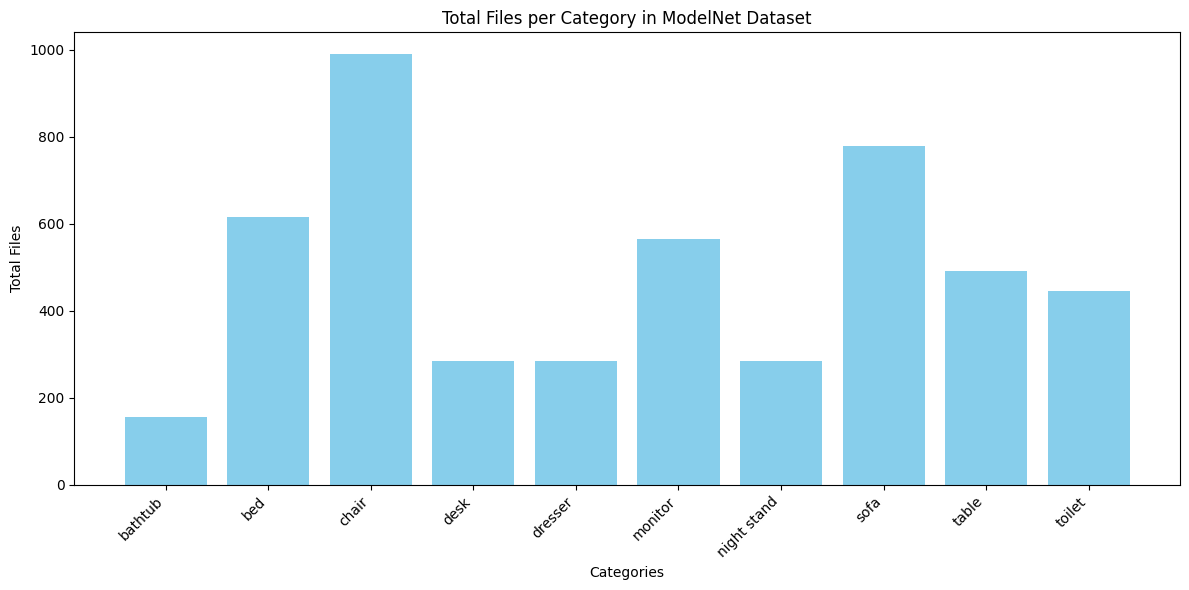

Amount of samples per category
bathtub - 156
bed - 617
chair - 991
desk - 286
dresser - 286
monitor - 565
night stand - 286
sofa - 780
table - 492
toilet - 446


In [3]:
graph_modelnet_data("C:/Users/jwilder/home/data/ModelNet10")

## Make Dataset Class

The dataset class will be responsible for generating our dataset as well as storing the dataset

In [45]:
class ModelNetDataset():
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.pointcloud_files = []
        self.entries = []
        self._initialize_dataset()

    def mesh_to_pointcloud(self, file_path: str, num_points: int = 4096):
        mesh = o3d.io.read_triangle_mesh(file_path)
        mesh.compute_vertex_normals()
        pcd = mesh.sample_points_uniformly(number_of_points=num_points)

        points = np.asarray(pcd.points, dtype=np.float32)

        centered_pointcloud = points - np.mean(points, axis=0)
        norm_pointcloud = centered_pointcloud / np.max(np.linalg.norm(centered_pointcloud, axis=1))

        return norm_pointcloud
    
    def add_noise_to_pcd(self, pcd: torch.tensor, num_noise_points: int, offset_strength: float = .1) -> torch.tensor:
        """Obfuscate a point cloud by adding random noisy points."""
        num_points = pcd.size(0)
        noise_points = []

        for _ in range(num_noise_points):
            random_idx = torch.randint(0, num_points, (1,)).item()
            random_offset = torch.FloatTensor(3).uniform_(-offset_strength, offset_strength)

            noisy_point = pcd[random_idx] + random_offset
            noise_points.append(noisy_point)

        noise_points = torch.stack(noise_points)  # Shape: (num_noise_points, 3)
        combined_points = torch.vstack((pcd, noise_points))  # Shape: (N + num_noise_points, 3)
        return combined_points

    def _initialize_dataset(self):
        for folder in os.listdir(self.root_dir):
            subfolder = os.path.join(self.root_dir, folder)
            train_folder = os.path.join(subfolder, "train")
            test_folder = os.path.join(subfolder, "test")

            for file in os.listdir(train_folder):
                file_path = os.path.join(train_folder, file)
                if not file_path.endswith(".off"): continue
                self.pointcloud_files.append(os.path.normpath(file_path))

            for file in os.listdir(test_folder):
                file_path = os.path.join(test_folder, file)
                if not file_path.endswith(".off"): continue
                self.pointcloud_files.append(os.path.normpath(file_path))

        for file_path in self.pointcloud_files:
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"Failed to initialize file path for data sample: {file_path}")

        self.length = len(self.pointcloud_files)

        for file in tqdm(self.pointcloud_files, desc="Generating point cloud dataset"):
            norm_points = self.mesh_to_pointcloud(file)
            pcd = torch.tensor(norm_points, dtype=torch.float32)
            noisy_pcd = self.add_noise_to_pcd(pcd, 2048, .2)
            self.entries.append({"noisy_pointcloud": noisy_pcd, "clean_pointcloud": pcd})


    def __len__(self) -> int:
        return self.length

    def __getitem__(self, index: int) -> str:
        return self.entries[index]

    def visualize_point_cloud(self, index: int):
        """Visualize a point cloud given as a PyTorch tensor."""

        clean_pcd = self.entries[index]["clean_pointcloud"]
        noisy_pcd = self.entries[index]["noisy_pointcloud"]

        points_np = noisy_pcd.cpu().numpy()
        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(points_np)
        o3d.visualization.draw_geometries([pcd_o3d], window_name="Point Cloud Visualization")

    def plot_entry(self, index: int):
        """Visualize the clean and noisy point clouds of a specific entry in the dataset."""
        clean_pcd = self.entries[index]["clean_pointcloud"]
        noisy_pcd = self.entries[index]["noisy_pointcloud"]

        fig = plt.figure(figsize=(12, 6))

        point_clouds = [noisy_pcd, clean_pcd]
        num_pcs = len(point_clouds)

        for i, points in enumerate(point_clouds):
            points_np = points.cpu().numpy()
            
            ax = fig.add_subplot(1, num_pcs, i + 1, projection='3d')
            ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], s=1)  # s is the size of points

            ax.set_title(f'{"Clean Output" if i != 0 else "Noisy Input"} Point Cloud')

            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.set_zlim(-1, 1)

        plt.tight_layout()
        plt.show()

In [46]:
dataset = ModelNetDataset("C:/Users/jwilder/home/data/ModelNet10")

Generating point cloud dataset: 100%|██████████| 4899/4899 [03:36<00:00, 22.66it/s]


Now let's visualize some example entries

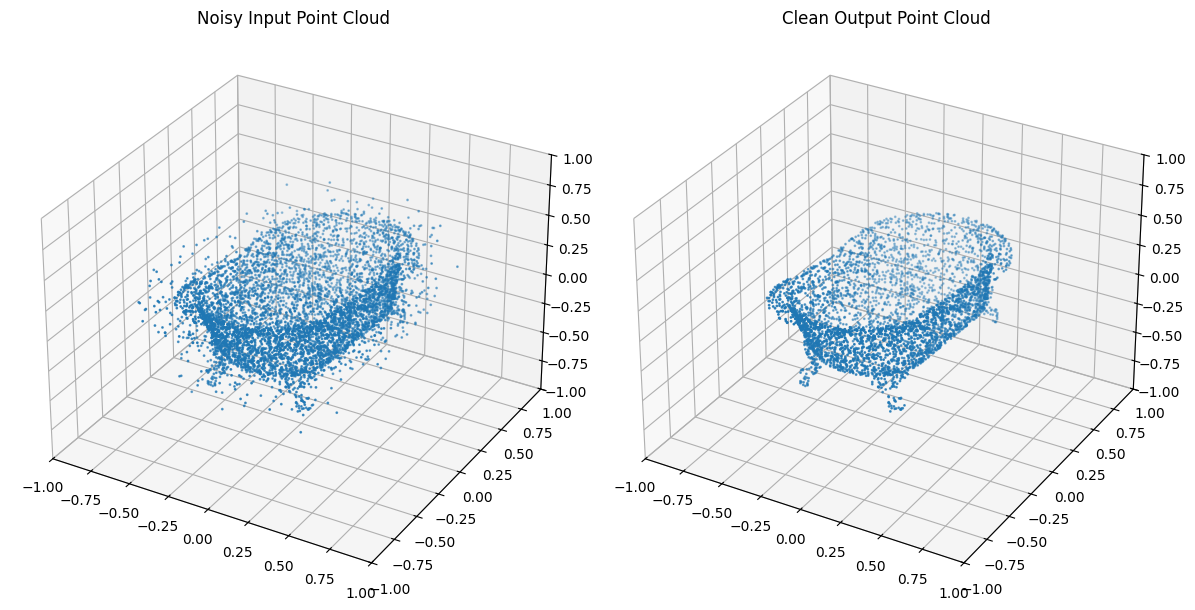

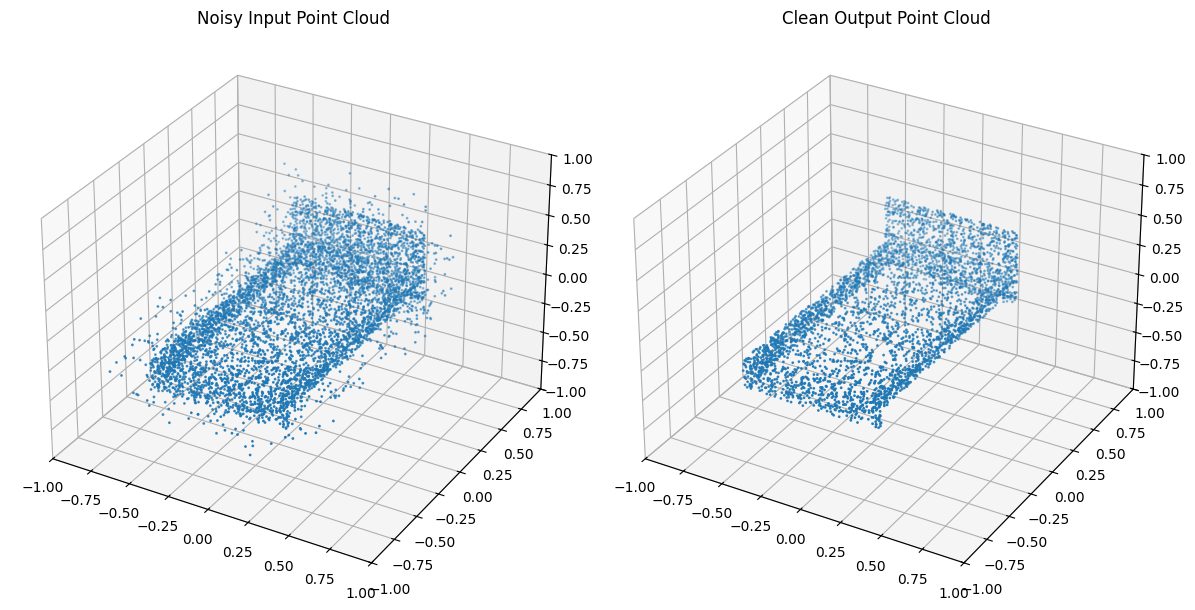

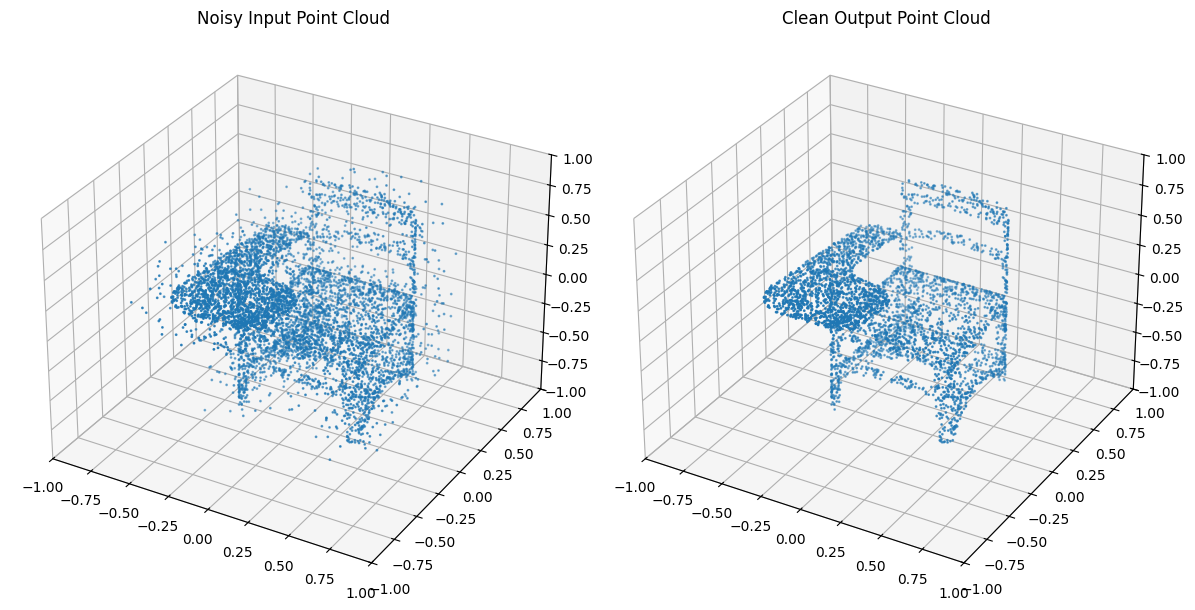

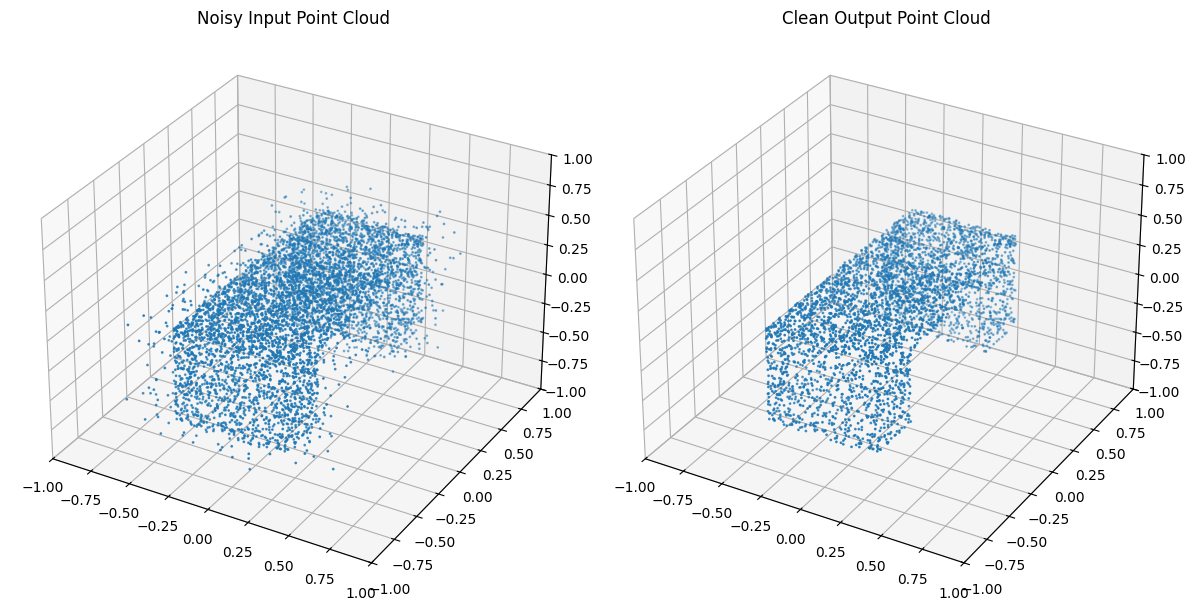

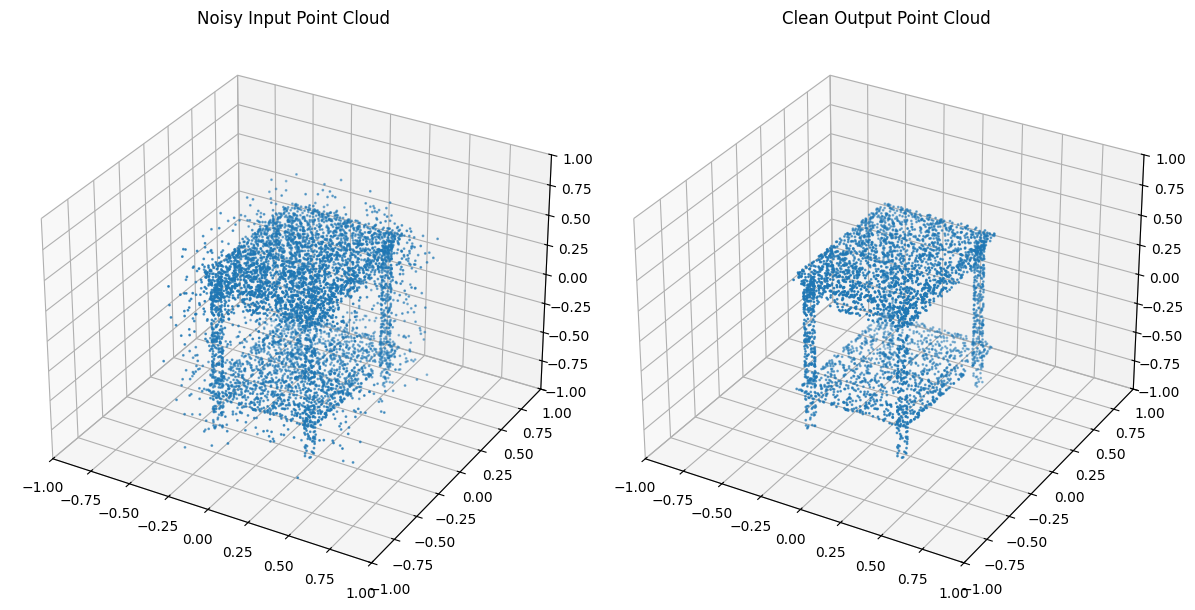

In [47]:
object_idxs = [4, 305, 800, 1805, 3000]

for idx in object_idxs:
    dataset.plot_entry(idx)

#dataset.visualize_point_cloud(object_idxs[0])


Tnet - responsible for learning a transformation matrix that will make the pointcloud invariant to rigid transformations, including position shifts and rotations

In [ ]:
class DenoiseNet(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        pass